In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))
qm_results = pickle.load(open('../data/qm_results.pickle', 'rb'))



# specify the system you want to simulate
#name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
name = 'molDWRow_590'


from_mol_tautomer_idx = 2
to_mol_tautomer_idx = 1


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit mol
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

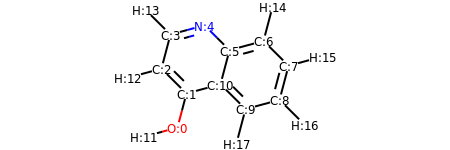

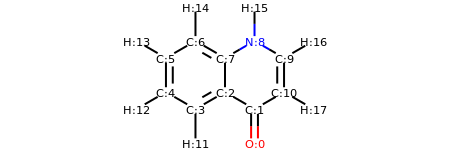

In [4]:
neutromeratio.display_mol(mols['t1'])
neutromeratio.display_mol(mols['t2'])

[utils.py:48 - get_tautomer_transformation()] Index of atom that moves: 15.
[utils.py:54 - get_tautomer_transformation()] Index of atom that donates hydrogen: 8
[utils.py:72 - get_tautomer_transformation()] Index of atom that accepts hydrogen: 0


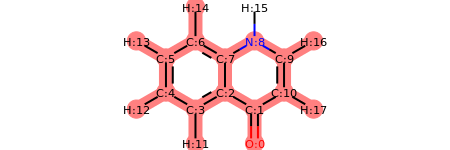

In [7]:
# extract hydrogen donor idx and hydrogen idx for from_mol
tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalANI(alchemical_atom=tautomer_transformation['hydrogen_idx'])
model = model.to(device)
torch.set_num_threads(2)

In [8]:
# number of time steps
nr_of_mc_trials = 400
nr_of_runs = 30

# generating mdtraj traj object
topology = md.load(f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb").topology


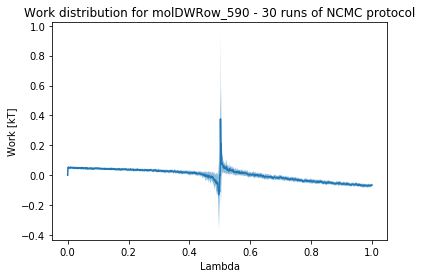

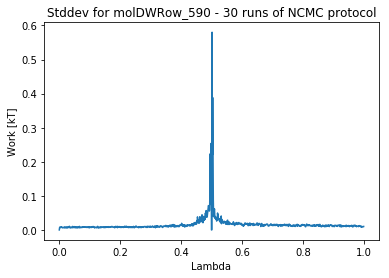

/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mwieder/anaconda3/envs/torchANI-dev/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


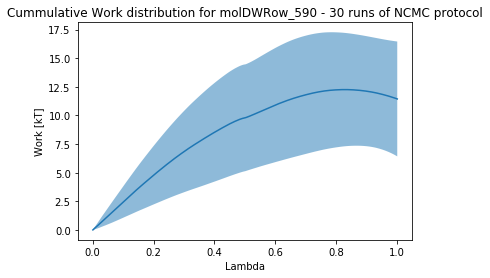

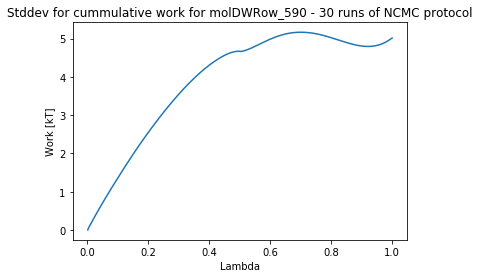

In [9]:
import matplotlib.pyplot as plt

work_in_runs = dict()
for run_nr in range(nr_of_runs):
    # read work values
    f = open(f"../data/md_mc_sampling/{name}/{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC_work_run_nr_{run_nr}.csv", 'r')
    work = []
    for line in f.readlines():
        i, j = line.split(',')
        work.append(float(j.rstrip()))
    work_in_runs[run_nr] = work
    f.close()


error = []
energy = []
for i in range(len(work_in_runs[0])):
    energy_list = []
    for n in work_in_runs:
        energy_list.append(work_in_runs[n][i])
        
    energy.append(np.mean(energy_list))
    error.append(np.std(energy_list))

plt.plot(np.linspace(0, 1, len(work_in_runs[0])), energy)
plt.fill_between(np.linspace(0, 1, len(work_in_runs[0])), np.array(energy)-np.array(error), np.array(energy) + np.array(error), alpha=0.5)
plt.title(f"Work distribution for {name} - {nr_of_runs} runs of NCMC protocol")
plt.xlabel('Lambda')
plt.ylabel('Work [kT]')
plt.savefig(f"../data/md_mc_sampling/{name}/work_summary_{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC.png")
plt.show()


plt.plot(np.linspace(0, 1, len(error)), error)
plt.title(f"Stddev for {name} - {nr_of_runs} runs of NCMC protocol")
plt.xlabel('Lambda')
plt.ylabel('Work [kT]')
plt.savefig(f"../data/md_mc_sampling/{name}/work_stddev_{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC.png")
plt.show()


error = []
energy = []
for i in range(len(work_in_runs[0])):
    energy_list = []
    for n in work_in_runs:
        energy_list.append(np.cumsum(work_in_runs[n][:i]))
        
    energy.append(np.mean(energy_list[-1]))
    error.append(np.std(energy_list))


plt.plot(np.linspace(0, 1, len(work_in_runs[0])), energy)
plt.fill_between(np.linspace(0, 1, len(work_in_runs[0])), np.array(energy)-np.array(error), np.array(energy) + np.array(error), alpha=0.5)
plt.title(f"Cummulative Work distribution for {name} - {nr_of_runs} runs of NCMC protocol")
plt.xlabel('Lambda')
plt.ylabel('Work [kT]')
plt.savefig(f"../data/md_mc_sampling/{name}/work_csum_summary_{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC.png")
plt.show()


plt.plot(np.linspace(0, 1, len(error)), error)
plt.title(f"Stddev for cummulative work for {name} - {nr_of_runs} runs of NCMC protocol")
plt.xlabel('Lambda')
plt.ylabel('Work [kT]')
plt.savefig(f"../data/md_mc_sampling/{name}/work_csum_stddev_{name}_from_t{from_mol_tautomer_idx}_to_t{to_mol_tautomer_idx}_NCMC.png")
plt.show()



In [ ]:
print(len(work_in_runs[0]))
print(len(set(work_in_runs[0])))


In [ ]:
top_file = f"../data/structures/{name}/{name}_tautomer_{from_mol_tautomer_idx}.pdb",
traj_files = [f"../data/md_mc_sampling/{name}/{name}_nonequilibrium_t{from_mol_tautomer_idx}_anicxx.dcd"]


In [ ]:
neutromeratio.utils.generate_nglview_object(
    top_file=top_file,
    traj_files=traj_files
)